In [51]:
import os
import tarfile
import urllib.request
import warnings
warnings.filterwarnings("ignore")

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [24]:
fetch_housing_data()

In [25]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
    

In [74]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [27]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [28]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [29]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


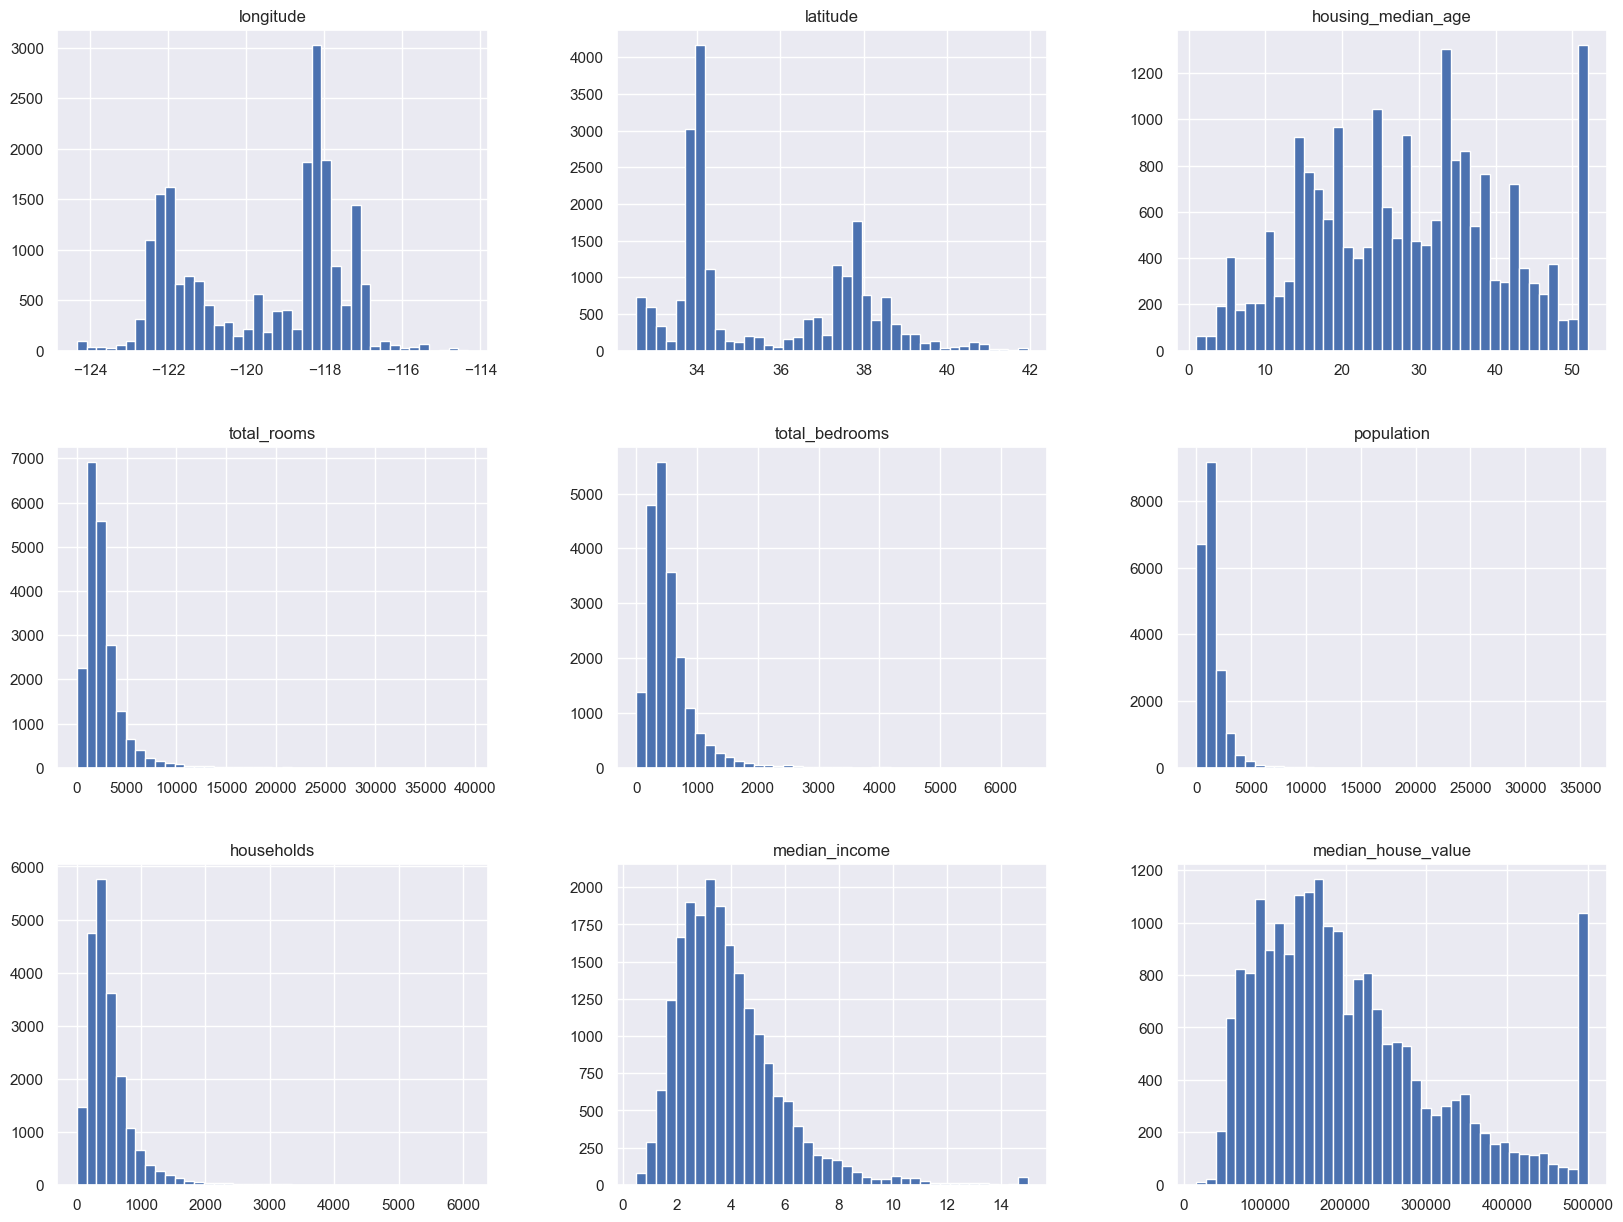

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

housing.hist(bins=40, figsize=(20,15))
plt.show()

### Setting aside a test set

In [42]:
import numpy as np
np.random.seed(42)

In [75]:
def split_train_test(data, test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [76]:
train_set, test_set=split_train_test(housing, 0.2)
len(train_set)

16512

In [77]:
len(test_set)

4128

In [78]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


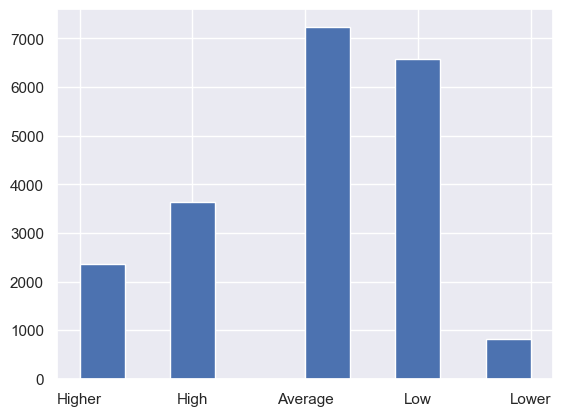

In [79]:
#just for fun: create categories in the income column
housing['income_cat']=pd.cut(housing['median_income'],
                         bins=[0.,1.5,3.0,4.5,6.,np.inf],
                         labels=['Lower','Low','Average','High','Higher'])
housing['income_cat'].hist();

In [80]:
#do some stratified sampling

from sklearn.model_selection import StratifiedShuffleSplit

st=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in st.split(housing, housing['income_cat']):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]

In [83]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

Average    0.350533
Low        0.318798
High       0.176357
Higher     0.114341
Lower      0.039971
Name: income_cat, dtype: float64

In [82]:
housing['income_cat'].value_counts()/len(housing)

Average    0.350581
Low        0.318847
High       0.176308
Higher     0.114438
Lower      0.039826
Name: income_cat, dtype: float64

In [84]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100


<IPython.core.display.Javascript object>

In [85]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
Lower,0.039826,0.039971,0.040213,0.973236,0.364964
Low,0.318847,0.318798,0.324370,1.732260,-0.015195
Average,0.350581,0.350533,0.358527,2.266446,-0.013820
High,0.176308,0.176357,0.167393,-5.056334,0.027480
Higher,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [87]:
strat_train_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [88]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [89]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
15940,-122.41,37.72,35.0,2104.0,434.0,1225.0,410.0,4.8214,242900.0,NEAR BAY
10335,-117.78,33.82,12.0,6208.0,750.0,2443.0,739.0,9.1808,413700.0,<1H OCEAN
20026,-119.05,36.06,23.0,2344.0,407.0,1184.0,406.0,3.1625,70600.0,INLAND
19059,-122.49,38.22,33.0,1486.0,290.0,781.0,274.0,3.5647,251800.0,NEAR BAY
804,-122.06,37.65,33.0,1227.0,286.0,848.0,291.0,3.8036,158200.0,NEAR BAY


### EDA

In [90]:
#create a copy
housing=strat_train_set.copy()

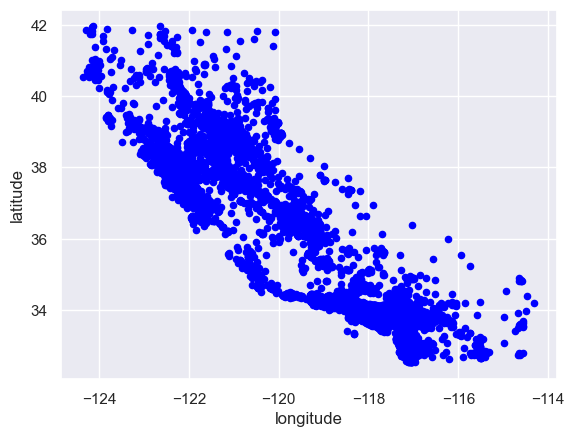

In [96]:
#Visualizing Geographical data
housing.plot(kind='scatter', x='longitude', y='latitude', c='blue');

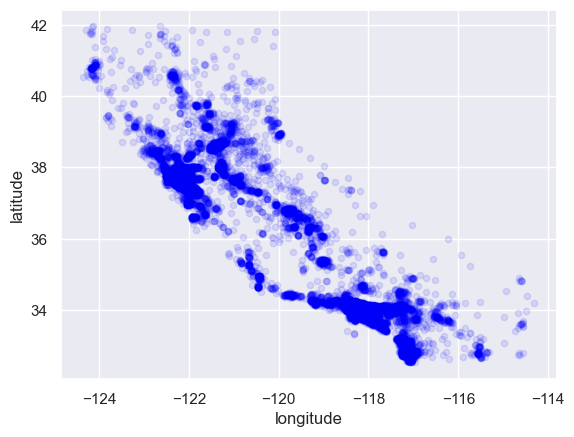

In [99]:
#high density areas
housing.plot(kind="scatter", x="longitude", y="latitude", c='blue', alpha=0.1);

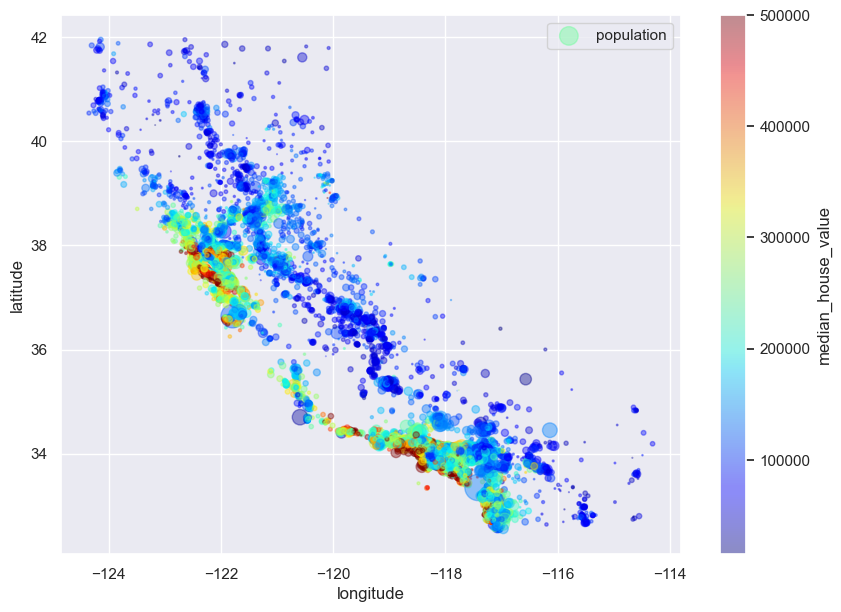

In [104]:
#for even better visualizations
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend();

In [106]:
# Download the California image
PROJECT_ROOT_DIR="."
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x1cc900b6760>)

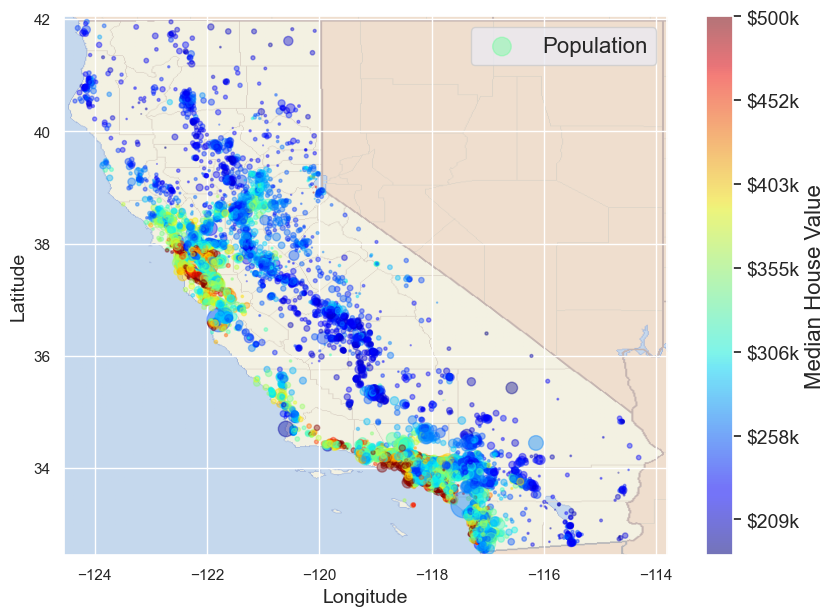

In [108]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show();

### Correlations

In [109]:
corr_matrix=housing.corr()

In [110]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688680
total_rooms           0.136809
housing_median_age    0.099939
households            0.067921
total_bedrooms        0.051541
population           -0.023099
longitude            -0.047758
latitude             -0.144249
Name: median_house_value, dtype: float64

In [ ]:
from pandas.plotting import scatter_matrix